## Tutorial for Language Modeling with NN.Transformer and TorchText

Refer to the origianl contents [Pytorch Tutorial](https://pytorch.org/tutorials/beginner/transformer_tutorial.html)

A tutorial for training seq2seq model that using the encoder part of Transformer module

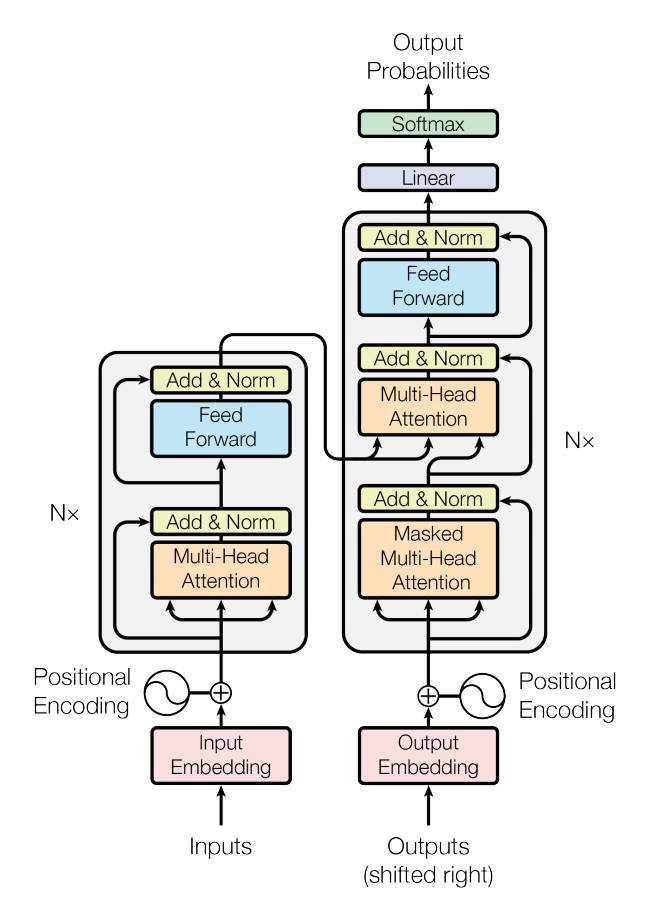

## Introduction
The overall model consists of the following parts:
- [1. Initiate an instance (model hyperparameters)](#1.-Initiate-an-instance)
- [2. Model Definition](#2.-Model-definition)
- [3. Dataset Loader](#3.-Data-loader)
- [4. Preprocessing (generate input and target sequence)](#4.-Pre-processing)
- [5. Training](#5.-Training)
- [6. Evaluation](#6.-Evaluation)

### 1. Initiate an instance

Define model hyper parameters

In [1]:
emsize = 512  # embedding dimension
d_hid = 1024  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 6  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 8  # number of heads in nn.MultiheadAttention
dropout = 0.2  # dropout probability
lr = 0.5
epochs = 10
optimizer = 'sgd'

### 2. Model Definition
A encoder model on a language modeling task that assigns a probability for likelihood of a given word to follow a sequence of words.

- `nn.TransformerEncoder` : consists of multiple layers of `nn.TransformerEncoderLayer`.
- `nn.TransformerEncoderLayer` : A layer of transformer encoder.
- At the end of the layer, the output is forwarded to the log-softmax function.

In [2]:
import math
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

class TransformerLanguageModel(nn.Module):
    def __init__(self, ntoken: int, d_model: int, nhead:int, d_hid: int, 
                 nlayer: int, dropout: float= 0.5):
        super().__init__()
        self.model_type='Transformer'
        self.pos_encoder=PositionalEncoding(d_model, dropout) # Add Positional Encoding
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout) 
        self.transformer_encoder=TransformerEncoder(encoder_layers, nlayers)
        self.encoder=nn.Embedding(ntoken,d_model) # Embedding ntoken into d-dimensional ... --> 3 --> [0.1, -0.2, 0.3] like constellation
        self.d_model = d_model
        self.decoder = nn.Linear(d_model,ntoken) # To obtain the probability of the following word.
        
    def init_weights(self) -> None:
        initrange=0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)
        
    def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:
        """
        Args: 
            src: Tensor with shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]
            
        Returns: output Tensor of shape [seq_len, batch_size, ntoken]
        """
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,src_mask)
        output= self.decoder(output)
        return output

/home/jgjang/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

### 3. Data loader

Load `Wikitext-2` data from torchtext.

- `batchify(data, bsz)`: arranges the data into batch_size (bsz) columns 

Example)

data: $[A, B, C, D, E, F, G, H, I]$

bsz: $2$

batchify(data,bsz) -> $\begin{bmatrix} A & E \\ B & F \\ C & G \\ D & H \end{bmatrix}$

Original data

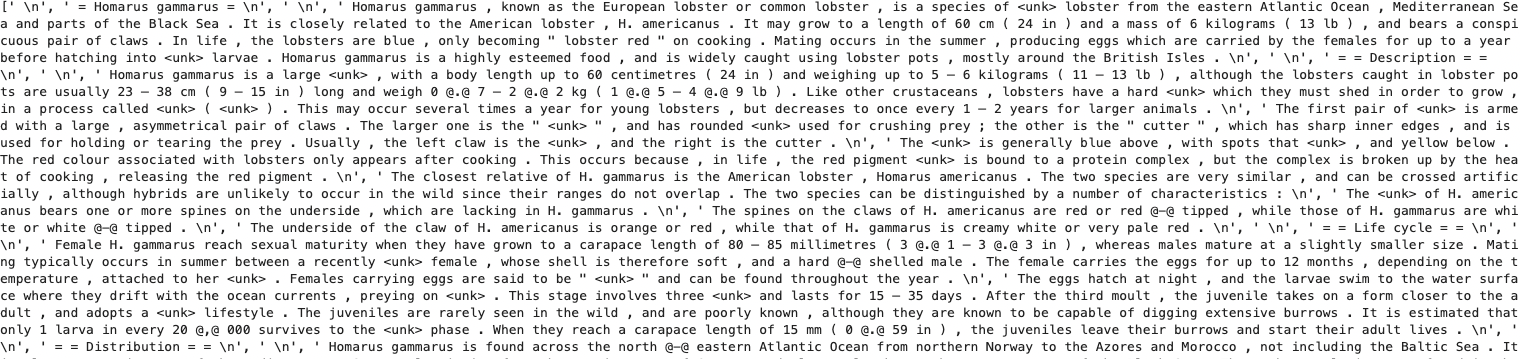

Output: encoded matrix of data [seq_len] x [batch_size]

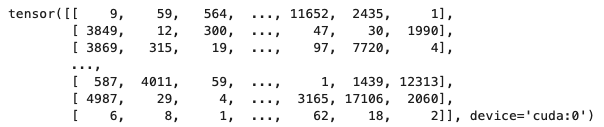


In [39]:
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

train_iter = WikiText2('./data', split='train')
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

def data_process(raw_text_iter: dataset.IterableDataset) -> Tensor:
    """Converts raw text into a flat Tensor."""
    data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

# train_iter was "consumed" by the process of building the vocab,
# so we have to create it again
train_iter, val_iter, test_iter = WikiText2()
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def batchify(data: Tensor, bsz: int) -> Tensor:
    """Divides the data into bsz separate sequences, removing extra elements
    that wouldn't cleanly fit.

    Args:
        data: Tensor, shape [N]
        bsz: int, batch size

    Returns:
        Tensor of shape [N // bsz, bsz]
    """
    seq_len = data.size(0) // bsz
    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size)  # shape [seq_len, batch_size]
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

In [5]:
ntokens=len(vocab)
model = TransformerLanguageModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)

### 4. Pre-processing
Tuple(input tensor, Output tensor)


In [6]:
bptt = 35
def get_batch(source: Tensor, i: int) -> Tuple[Tensor, Tensor]:
    """
    Args:
        source: Tensor, shape [full_seq_len, batch_size]
        i: int

    Returns:
        tuple (data, target), where data has shape [seq_len, batch_size] and
        target has shape [seq_len * batch_size]
    """
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

### 5. Training

In [7]:
criterion = nn.CrossEntropyLoss()
if optimizer == 'sgd':
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def generate_square_subsequent_mask(sz: int) -> Tensor:
    """
    Generate an upper-triangular matrix of -inf, with zeros on diag.
    0, -inf, -inf, 
    0,    0, -inf,
    0,    0,    0,
    """
    return torch.triu(torch.ones(sz,sz)* float('-inf'), diagonal=1)
    
def train(model: nn.Module) -> None:
    model.train()
    total_loss = 0.
    log_interval=200
    start_time = time.time()
    src_mask = generate_square_subsequent_mask(bptt).to(device)
    
    num_batches = len(train_data) //bptt
    for batch, i in enumerate(range(0,train_data.size(0) -1, bptt)): # if bptt = 35, train_data.size(0) = 100 --> i --> 0,  35, 70
        data, targets = get_batch(train_data, i)
        batch_size = data.size(0)
        if not batch_size == bptt: # if batchsize < bptt 
            src_mask = src_mask[:batch_size, :batch_size]
        output = model(data, src_mask)
        loss = criterion(output.view(-1, ntokens), targets)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        
        total_loss += loss.item()
        if batch % log_interval ==0 and batch>0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches |'
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:2.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss =0
            start_time = time.time()
def evaluate(model: nn.Module, eval_data: Tensor) -> float:
    model.eval()
    total_loss = 0.
    src_mask = generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
        for i in range(0, eval_data.size(0) -1 , bptt):
            data, targets = get_batch(eval_data, i)
            batch_size = data.size(0)
            if batch_size != bptt :
                src_mask = src_mask[:batch_size, :batch_size]
            output = model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += batch_size * criterion(output_flat, targets).item()
    return total_loss / (len(eval_data)-1)
    

In [8]:
import time 
import copy
best_val_loss = float('inf')
best_model = None
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(model)
    val_loss = evaluate(model, val_data)
    val_ppl = math.exp(val_loss)
    elapsed = time.time() - epoch_start_time
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time {elapsed:5.2f}s| '
          f'valid_loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
    print('-' * 89)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
    
    scheduler.step()

| epoch   1 |   200/ 2928 batches |lr 0.50 | ms/batch 29.98 | loss  7.50 | ppl  1812.49
| epoch   1 |   400/ 2928 batches |lr 0.50 | ms/batch 28.80 | loss  6.95 | ppl  1042.46
| epoch   1 |   600/ 2928 batches |lr 0.50 | ms/batch 29.02 | loss  6.78 | ppl   875.73
| epoch   1 |   800/ 2928 batches |lr 0.50 | ms/batch 29.25 | loss  6.71 | ppl   822.16
| epoch   1 |  1000/ 2928 batches |lr 0.50 | ms/batch 30.06 | loss  6.65 | ppl   769.85
| epoch   1 |  1200/ 2928 batches |lr 0.50 | ms/batch 28.96 | loss  6.63 | ppl   754.61
| epoch   1 |  1400/ 2928 batches |lr 0.50 | ms/batch 29.29 | loss  6.55 | ppl   701.35
| epoch   1 |  1600/ 2928 batches |lr 0.50 | ms/batch 29.20 | loss  6.54 | ppl   693.09
| epoch   1 |  1800/ 2928 batches |lr 0.50 | ms/batch 29.26 | loss  6.49 | ppl   655.75
| epoch   1 |  2000/ 2928 batches |lr 0.50 | ms/batch 29.39 | loss  6.48 | ppl   654.22
| epoch   1 |  2200/ 2928 batches |lr 0.50 | ms/batch 29.69 | loss  6.38 | ppl   591.40
| epoch   1 |  2400/ 2928 batche

### 6. Evaluation

In [9]:
test_loss = evaluate(best_model, test_data)
test_ppl = math.exp(test_loss)
print('=' * 89)
print(f'| End of training | test loss {test_loss:5.2f} | '
      f'test ppl {test_ppl:8.2f}')
print('=' * 89)

| End of training | test loss  5.33 | test ppl   206.90


Inference with custom example

In [156]:
source = 'The two species can be '
print(f'Your original sentence: \n {source}')
book = vocab.get_itos() #textbook

#data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]

example = tokenizer(source)
text2voc = torch.tensor([vocab([item]) for item in example]).to(device)
def inference(model: nn.Module, data: Tensor) -> float:
    model.eval()
    src_mask = generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
        seq_len = data.size(0)
        if seq_len != bptt :
            src_mask = src_mask[:seq_len, :seq_len]
        output = model(data, src_mask)
        output_flat = output.view(-1, ntokens)
        output_flat = torch.argmax(output_flat, dim=1)
        next_word = book[output_flat[-1]]
    return output_flat[-1], next_word
text2voc = text2voc[-34:]
for i in range(30):
    output, word = inference(best_model, text2voc)
    text2voc = torch.cat((text2voc[-34:], output.view([1,1])))
    source = source + ' ' + word


print(f'Generated sentence : \n {source}')


Your original sentence: 
 The two species can be 
Generated sentence : 
 The two species can be  found in the <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk>
